#  MIR Embedding Analysis Demo  
### *PCA Visualization, Clustering, and Instrument Separability*

This notebook demonstrates the workflow used to analyze instrument embeddings generated by AudioMAE and OpenL3.  
The goal is to understand how well these embeddings preserve instrument identity across different recording conditions, including **dry**, **reverb**, and **distortion**.

---

## 📌 What This Notebook Covers
- Loading embeddings and instrument metadata  
- Running **K-means clustering** on high-dimensional embeddings
- Visualizing embedding structure with **PCA 2D**  
- Comparing cluster assignments with true instrument labels  
- Evaluating model performance using:
  - Adjusted Rand Index (ARI)  
  - Normalized Mutual Information (NMI)  
  - Confusion matrices  
- Side-by-side comparisons across models and conditions  


In [3]:
import numpy as np

import os, json, datetime, argparse, numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix

import pandas as pd

In [4]:
#replace path name with your own
#csv_path = "/Users/xinranchen/Downloads/audio_labels.csv"
openL3_path = "/Users/xinranchen/Desktop/MIRGroupAssignment/noise/openl3_mel256_music_512/"
audioMAE_path = "/Users/xinranchen/Desktop/MIRGroupAssignment/noise/audiomae_base_768/"
save_path = "/Users/xinranchen/Desktop/MIRGroupAssignment/graph/noise"
pathFolder = ["ambience", "applause", "bird", "crowd", "fan", "microphone", "rain", "street", "talking", "white_noise" ]

In [5]:

# Read the CSV (replace 'yourfile.csv' with your actual filename)
df = pd.read_csv("audio_labels.csv", header=None)

# Select rows 1 to 1000 (Python slicing: row index 1 to 1000 inclusive)
subset = df.iloc[1:1001, :]

# Assign column names for clarity
subset = subset.rename(columns={1: "instrument", 4: "id"})

data_dict = dict(zip(subset["id"], subset["instrument"]))

**Utility Functions**

In [6]:
def loadFolder(folder_path):
    # -----------------------------
    # Load and stack .npy files
    # -----------------------------
    #file_list = sorted([f for f in os.listdir(folder_path) if f.endswith(".npy")])
    file_list = [f for f in os.listdir(folder_path) if f.endswith(".npy")]
    
    all_arrays = []
    instrument_list = []
    id_list = []
    
    for fname in file_list:
        # Extract ID from filename (remove extension)
        file_id = os.path.splitext(fname)[0]
    
        # Load array
        arr = np.load(os.path.join(folder_path, fname))
        all_arrays.append(arr)
    
        # Look up instrument using ID
        instrument = data_dict.get(file_id, "UNKNOWN")
        instrument_list.append(instrument)
        id_list.append(file_id)
    
    # Stack into matrix
    X = np.stack(all_arrays, axis = 0)
    return X, instrument_list, id_list

In [ ]:
def k_means_clustering(X, instrument_list, title):
    '''
    produce k-means clustering graph colored by cluster & by instrument, confusion matrix and the NMI and ari scores

    Parameters
    ----------
    X : npdarry
        Matrix with 1000 entries of embeddings
    
    instrument_list : list
        Version of the dataset to load. Default is "1.1.0".
    
    title : str
        name of the folder(process effect) 

    Returns
    -------
    nmi: score comparing k-means cluster and instrument groups
    ari: score comparing k-means cluster and instrument groups

    '''
    
    n_clusters = len(set(instrument_list))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    K = kmeans.n_clusters
    #kmeans = KMeans(n_clusters=k, random_state=0)
    #labels = kmeans.fit_predict(X)  # labels for each point
    pca = PCA(n_components=2) 
    X2 = pca.fit_transform(X)

    centroids = kmeans.cluster_centers_
    centroids_2d = pca.transform(centroids) 
    
    cmap_clusters = plt.cm.get_cmap("tab10", K)    
    
    #plotting 
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # color by Cluster
    axes[0].scatter(
        X2[:,0], X2[:,1],
        c=cluster_labels,
        cmap = cmap_clusters,
        s=20, alpha=0.7
    )
    
    # centroids (colored by cluster)
    axes[0].scatter(
        centroids_2d[:,0], centroids_2d[:,1],
        marker='X', s=260,
        c=np.arange(K),
        cmap = cmap_clusters,
        edgecolor='black', linewidth=1.5
    )
    
    axes[0].set_title(f"{"K-means Colored by Cluster - "}{title}")
    axes[0].set_xlabel("PC1")
    axes[0].set_ylabel("PC2")
    

# color by instrument
    unique_labels = np.unique(instrument_list)
    num_inst = len(unique_labels)
    cmap_instruments = plt.cm.get_cmap("tab10", num_inst)
    

    label_to_num = {lab: i for i, lab in enumerate(unique_labels)}
    numeric_labels = [label_to_num[l] for l in instrument_list]
    
    axes[1].scatter(
        X2[:,0], X2[:,1],
        c=numeric_labels,
        cmap= cmap_instruments,
        s=20, alpha=1
    )

# Legend
    handles = []
    labels = []
    #stringLabels = []
    from sklearn.preprocessing import LabelEncoder
    enc = LabelEncoder()
    instrument_ids = enc.fit_transform(instrument_list)
    unique_ids = np.unique(instrument_ids)
    unique_instruments = enc.inverse_transform(unique_ids)
    
    for color_id, inst_name in zip(unique_ids, unique_instruments):
        color = cmap_instruments(color_id)           # same colormap used in scatter
        handle = plt.Line2D([0], [0],
                            marker='o',
                            linestyle='',
                            markerfacecolor=color,
                            markeredgecolor='none')
        handles.append(handle)
    
        # If you have a dictionary mapping index → name
        #stringLabels.append(inst_dic.get(inst_name))
        labels.append(inst_name)
    axes[1].legend(handles, labels, title="Instrument", loc="best", fontsize=8)
    
    axes[1].set_title(f"{"K-means Colored by Instrument - "}{title}")
    axes[1].set_xlabel("PC1")
    axes[1].set_ylabel("PC2")
    
    plt.tight_layout()
    #plt.savefig(f"{"graph/noise/audioMAE/"}{title}{".png"}", dpi=300)
    plt.show()

#confusion matrix

    
   # str_cluster = list(map(str, cluster_labels))

    cm = confusion_matrix(numeric_labels, cluster_labels)
    
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f"{"Cluster vs Instrument Confusion Matrix - "}{title}")
    plt.colorbar()
    
    # Show numbers inside cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha='center', va='center',
                     color='black')
    
    
    plt.xlabel("Cluster")
    plt.ylabel("Instrument")
    plt.tight_layout()
    #plt.savefig(f"{"graph/noise/audioMAE/"}{"ConfusionMatrix"}{title}{".png"}", dpi=300)
    plt.show()
    
    ari = adjusted_rand_score(numeric_labels, cluster_labels)
    print("ARI:", ari)
    
    nmi = normalized_mutual_info_score(numeric_labels, cluster_labels)
    print("NMI:", nmi)

    return ari, nmi

**Example - graphs on audioMAE ambience effect**

/var/folders/d0/wgrhs6fx6572590ctdph7f900000gn/T/ipykernel_46480/3809721950.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_clusters = plt.cm.get_cmap("tab10", K)
/var/folders/d0/wgrhs6fx6572590ctdph7f900000gn/T/ipykernel_46480/3809721950.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_instruments = plt.cm.get_cmap("tab10", num_inst)


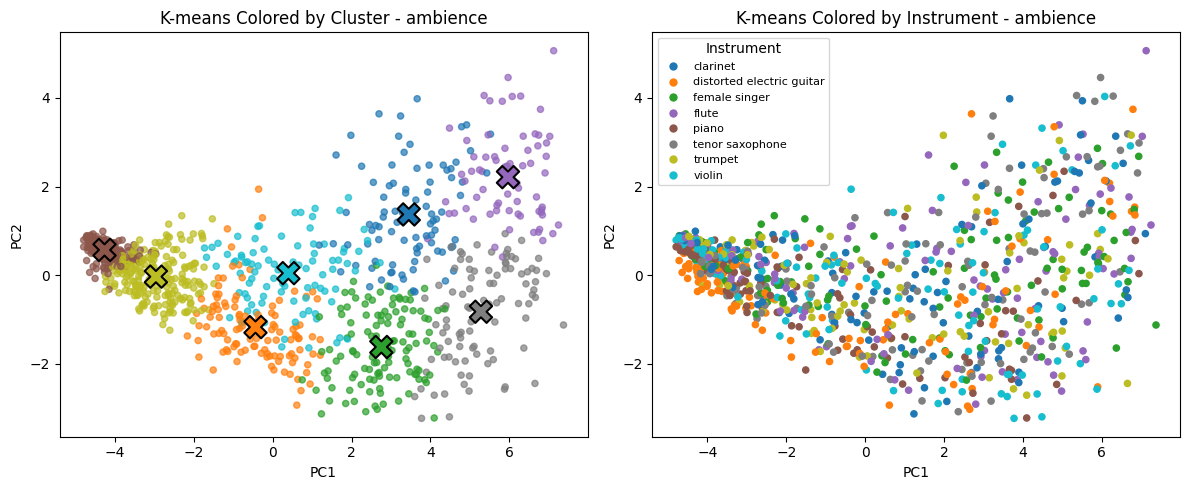

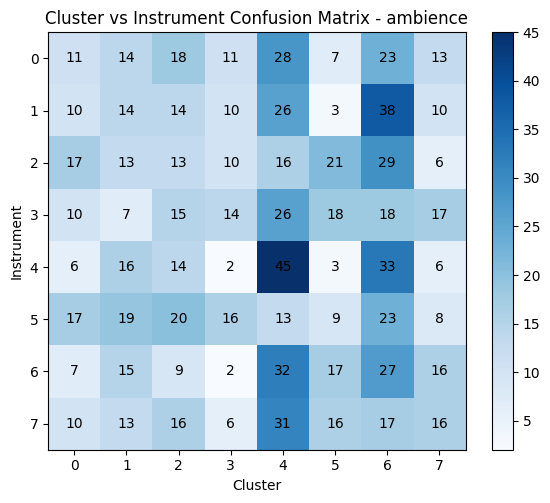

ARI: 0.010832961538224306
NMI: 0.032712333039203276


(0.010832961538224306, 0.032712333039203276)

In [8]:
X, instrument_list, id_list = loadFolder(f"{audioMAE_path}{"ambience"}")
k_means_clustering(X, instrument_list, "ambience")

**Example - graphs on audioMAE ambience effect**

/var/folders/d0/wgrhs6fx6572590ctdph7f900000gn/T/ipykernel_46480/3809721950.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_clusters = plt.cm.get_cmap("tab10", K)
/var/folders/d0/wgrhs6fx6572590ctdph7f900000gn/T/ipykernel_46480/3809721950.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_instruments = plt.cm.get_cmap("tab10", num_inst)


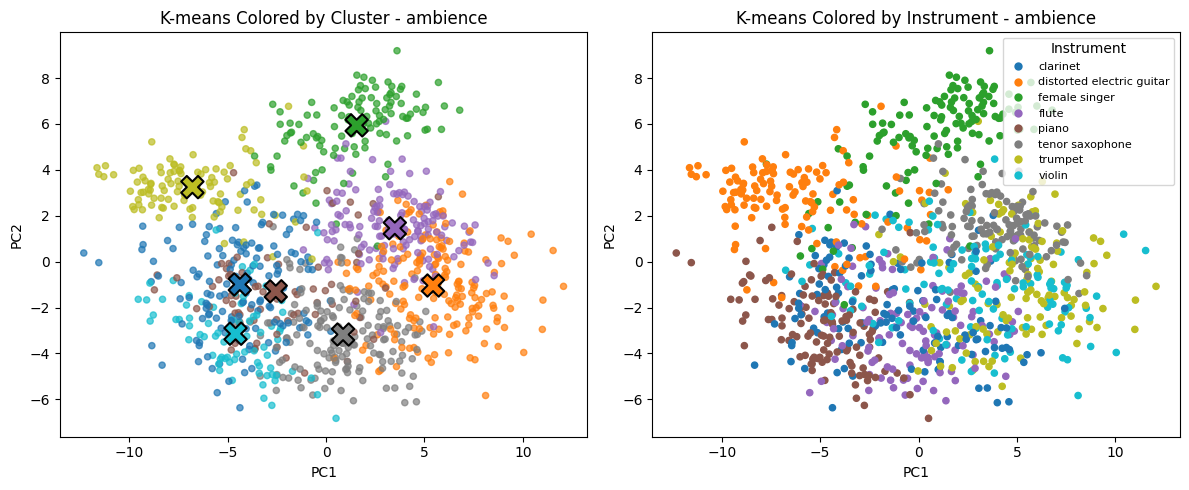

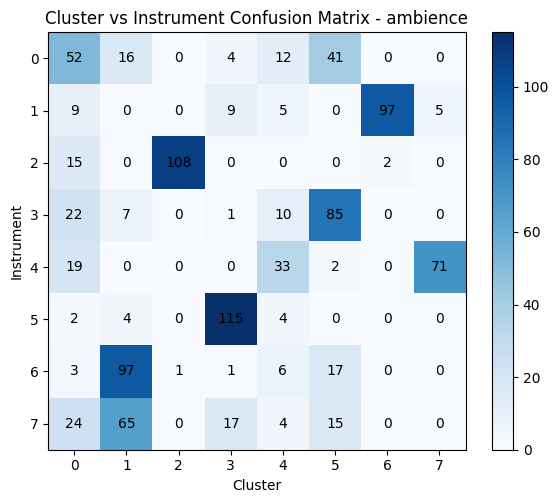

ARI: 0.4514906973414393
NMI: 0.5596043923562963


(0.4514906973414393, 0.5596043923562963)

In [9]:
X, instrument_list, id_list = loadFolder(f"{openL3_path}{"ambience"}")
k_means_clustering(X, instrument_list, "ambience")

**Example - graphs on openL3 all noise**

/var/folders/d0/wgrhs6fx6572590ctdph7f900000gn/T/ipykernel_46480/3809721950.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_clusters = plt.cm.get_cmap("tab10", K)
/var/folders/d0/wgrhs6fx6572590ctdph7f900000gn/T/ipykernel_46480/3809721950.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_instruments = plt.cm.get_cmap("tab10", num_inst)


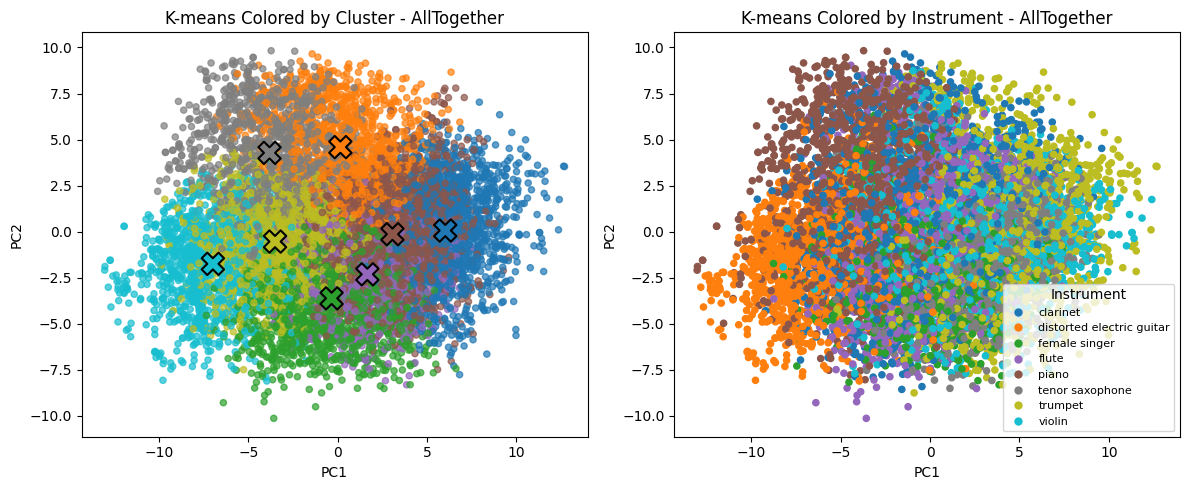

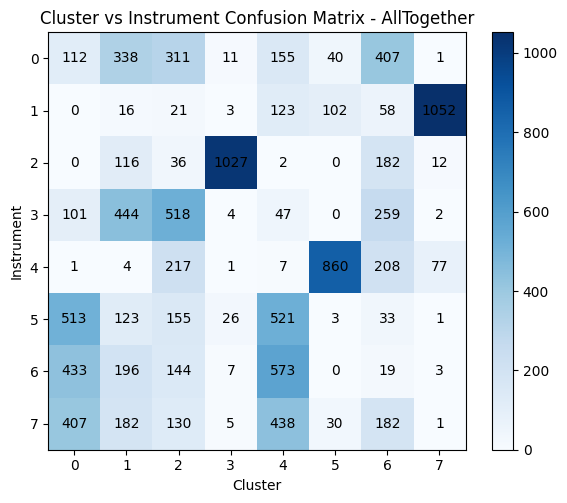

ARI: 0.2723389515406325
NMI: 0.3835249058296403


(0.2723389515406325, 0.3835249058296403)

In [10]:
#modify path to dry folder
X, instrument_list, id_list = loadFolder("/Users/xinranchen/Desktop/MIRGroupAssignment/openl3_mel256_music512/dry")

for i in pathFolder:
    path = f"{openL3_path}{i}"
    X_n, instrument_list_n, id_list_n = loadFolder(path)
    X = np.vstack([X, X_n])
    instrument_list = np.concatenate([instrument_list, instrument_list_n])

k_means_clustering(X, instrument_list, "AllTogether")